<a href="https://colab.research.google.com/github/Kinadim/ML_projet/blob/main/ML_PROJET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

# 1.Analyse des données

In [1]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et
#indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
!pip install pyspark



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pyspark
from pyspark.ml.linalg import Matrices
from pyspark.mllib.util import MLUtils

In [2]:
import pandas as pd

#attention le séparateur est une tabulation
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1140 non-null   int64  
 1   tweet_id              1140 non-null   int64  
 2   text                  1140 non-null   object 
 3   science_related       1140 non-null   int64  
 4   scientific_claim      1140 non-null   float64
 5   scientific_reference  1140 non-null   float64
 6   scientific_context    1140 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 62.5+ KB


None

In [4]:
df.describe()

,Unnamed: 0,tweet_id,science_related,scientific_claim,scientific_reference,scientific_context
count,1140.000000,1.140000e+03,1140.000000,1140.000000,1140.00000,1140.000000
mean,626.040351,8.560901e+17,0.328947,0.230702,0.17807,0.220175
std,364.412255,2.865422e+17,0.470037,0.421467,0.38274,0.414547
min,0.000000,3.166700e+17,0.000000,0.000000,0.00000,0.000000
25%,306.750000,6.176042e+17,0.000000,0.000000,0.00000,0.000000
50%,624.500000,8.615253e+17,0.000000,0.000000,0.00000,0.000000
75%,940.250000,1.103864e+18,1.000000,0.000000,0.00000,0.000000
max,1260.000000,1.344485e+18,1.000000,1.000000,1.00000,1.000000


### On observe la répartition des valeurs pour chaque colonne" 

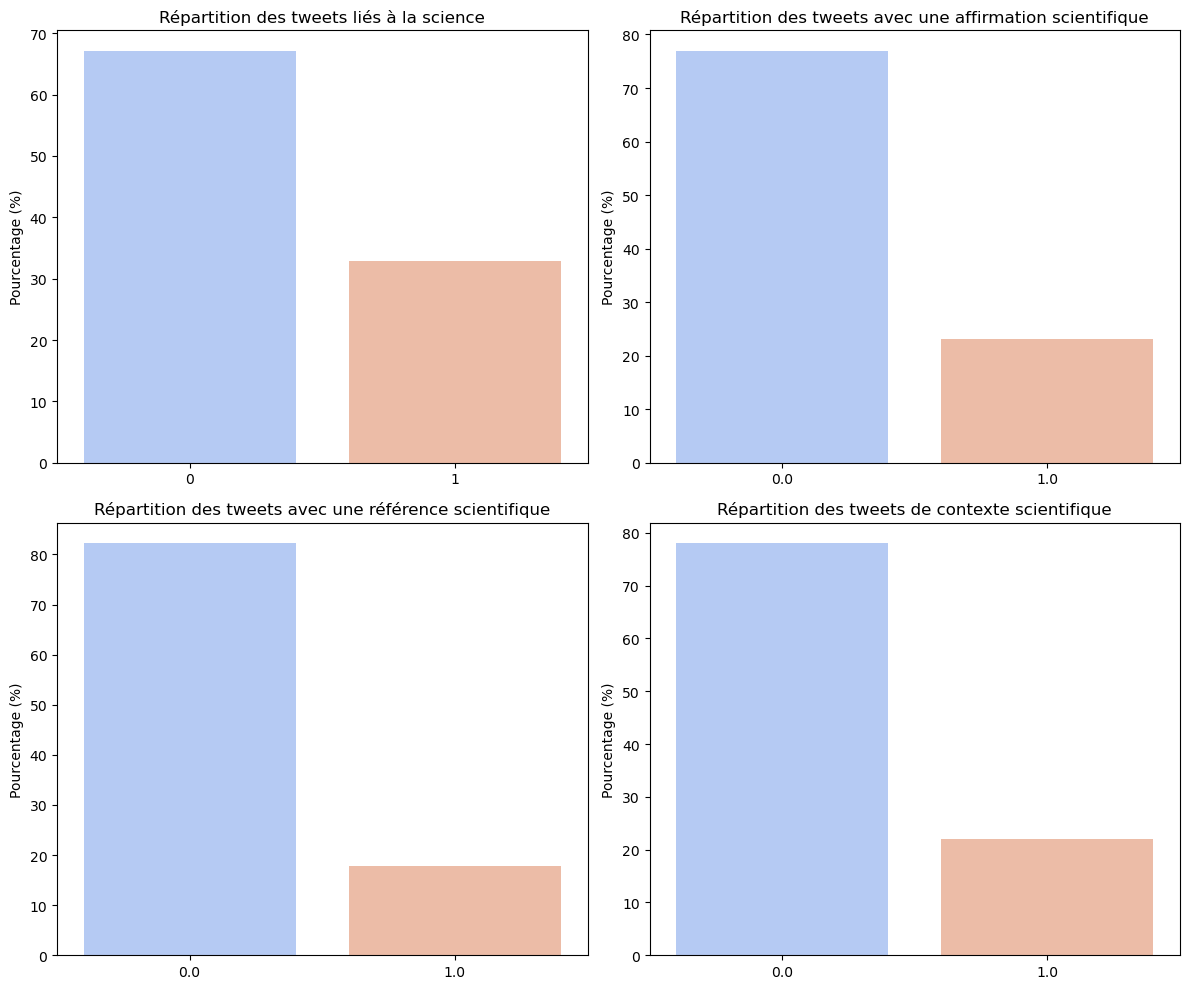

In [5]:
# Définir la figure avec 2 lignes et 2 colonnes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Liste des colonnes à afficher
columns = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']
titles = [
    "Répartition des tweets liés à la science",
    "Répartition des tweets avec une affirmation scientifique",
    "Répartition des tweets avec une référence scientifique",
    "Répartition des tweets de contexte scientifique"
]

# Générer les 4 countplots avec pourcentage
for ax, col, title in zip(axes.flat, columns, titles):
    total = len(df[col])  # Nombre total d'observations
    sns.barplot(
        x=df[col].value_counts(normalize=True).index,  # Valeurs uniques
        y=df[col].value_counts(normalize=True).values * 100,  # Pourcentage
        ax=ax, palette="coolwarm"
    )
    ax.set_title(title)
    ax.set_xlabel("")  # Supprimer les labels des axes X pour plus de lisibilité
    ax.set_ylabel("Pourcentage (%)")

# Ajuster l'espacement
plt.tight_layout()
plt.show()


On remarque que la majorité des tweets de notre dataset d'entrainement ne sont pas scienfifiques

### On regarde la densité de valeur présente

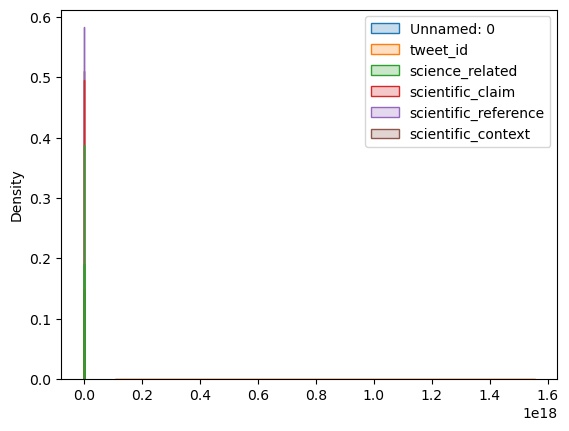

In [6]:
sns.kdeplot(data=df, fill=True)
plt.show()

# 2. Nettoyage des données

On a remarqué que certains tweets utilisant des mots qui n'était pas en anglais. Nous avons donc trouvé pour qu'un modèle fonctionne, il parait approprié de traduire les tweets en anglais. Pour cela nous allons utiliser les fonctionnalité de traduction proposé par Google. 

### Fonction pour traduire en anglais

In [7]:
!pip install deep-translator
!pip install mlutils
from deep_translator import GoogleTranslator

def translate_to_english(tweet):
    translated = GoogleTranslator(source='auto', target='en').translate(tweet)
    return translated

In [8]:
df['text'] = df['text'].apply(translate_to_english)
display(df)


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1135,1255,1340455669443350528,@LaylaFanucci @realDonaldTrump I'm sorry but w...,1,1.0,0.0,0.0
1136,1256,1340689510569549824,"Dear #NIN applicants, you can kindly download ...",0,0.0,0.0,0.0
1137,1258,1341155832793165825,Whats the uber support team email address?,0,0.0,0.0,0.0
1138,1259,1344167355648241664,House passes bill to increase stimulus checks ...,0,0.0,0.0,0.0


In [84]:
import itertools
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.stem import PorterStemmer # Racinisation des termes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Charger les données

# Définition des fonctions de prétraitement
def remove_links(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#', '', tweet, flags=re.MULTILINE)

def remove_mentions(tweet):
    return re.sub(r'\@\w+', '', tweet, flags=re.MULTILINE)

def remove_hashtags(tweet):
    return re.sub(r'\#+', '', tweet, flags=re.MULTILINE)

def to_lowercase(tweet):
    return tweet.lower()

def remove_punctuation(tweet):
    return re.sub(r'[^\w\s]', '', tweet)

def remove_stopwords(tweet):
    tokens = word_tokenize(tweet)
    return ' '.join([word for word in tokens if word not in stopwords.words('english')])

def lemmatize_words(tweet):
    tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

def stem_words(tweet):
    tokens = word_tokenize(tweet)
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tokens])


# Liste des transformations possibles
transformations = {
    "remove_links": remove_links,
    "to_lowercase": to_lowercase,
    "remove_punctuation": remove_punctuation,
    "remove_stopwords": remove_stopwords,
    "lemmatize_words": lemmatize_words,
    "remove_mentions": remove_mentions,
    "remove_hashtags": remove_hashtags,
    "stem_words": stem_words
}

# Générer toutes les combinaisons possibles des transformations
all_combinations = []
for i in range(1, len(transformations) + 1):
    all_combinations.extend(itertools.combinations(transformations.keys(), i))

# Stocker les résultats
results = []



train_test_list=list()

# Boucle sur chaque combinaison de transformations
for i, combination in enumerate(all_combinations):
    df_copy = df.copy()
    
    # Appliquer les transformations sélectionnées
    for transform in combination:
        df_copy['text'] = df_copy['text'].apply(transformations[transform])
    
    # Séparation des données
    X = df_copy['text']
    y = df_copy['science_related']
    
    # Vectorisation simple avec TF-IDF
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    # Séparation en train/test
    train_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)
    clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
    clf.fit(X_vectorized, y)
    train_test_list.append((i,combination,train_test,X_vectorized,clf))
    
    


"""
    # Modèle Decision Tree
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    
    # Stocker les résultats
    results.append({"combination": combination, "accuracy": accuracy})
    print(f"Test {i+1}/{len(all_combinations)} - {combination} -> Accuracy: {accuracy:.4f}")

# Afficher les meilleurs résultats
results_df = pd.DataFrame(results)
"""

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'\n    # Modèle Decision Tree\n    model = DecisionTreeClassifier()\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n\n    # Évaluation\n    accuracy = accuracy_score(y_test, y_pred)\n    \n    # Stocker les résultats\n    results.append({"combination": combination, "accuracy": accuracy})\n    print(f"Test {i+1}/{len(all_combinations)} - {combination} -> Accuracy: {accuracy:.4f}")\n\n# Afficher les meilleurs résultats\nresults_df = pd.DataFrame(results)\n'

### DecisionTreeClassifier

In [64]:
result_Decision_Tree_Classifier = []
for i in range (len(train_test_list)):
    ### Utilisation d'une random prédéfinie pour conserver les résultats
    model = DecisionTreeClassifier(random_state=5631)#5631
    train_test = train_test_list[i]
    train_test_value = train_test[2]
    model.fit(train_test_value[0],train_test_value[2])
    y_pred = model.predict(train_test_value[1])
    accuracy = accuracy_score(train_test_value[3], y_pred)
    result_Decision_Tree_Classifier.append({"combination": train_test[1], "accuracy": accuracy})
    print(f"Test {i+1}/{len(all_combinations)} - {train_test[1]} -> Accuracy: {accuracy:.4f}")
    
    

Test 1/255 - ('remove_links',) -> Accuracy: 0.7500
Test 2/255 - ('to_lowercase',) -> Accuracy: 0.7763
Test 3/255 - ('remove_punctuation',) -> Accuracy: 0.7149
Test 4/255 - ('remove_stopwords',) -> Accuracy: 0.7719
Test 5/255 - ('lemmatize_words',) -> Accuracy: 0.6930
Test 6/255 - ('remove_mentions',) -> Accuracy: 0.7895
Test 7/255 - ('remove_hashtags',) -> Accuracy: 0.7763
Test 8/255 - ('stem_words',) -> Accuracy: 0.7763
Test 9/255 - ('remove_links', 'to_lowercase') -> Accuracy: 0.7500
Test 10/255 - ('remove_links', 'remove_punctuation') -> Accuracy: 0.7632
Test 11/255 - ('remove_links', 'remove_stopwords') -> Accuracy: 0.7895
Test 12/255 - ('remove_links', 'lemmatize_words') -> Accuracy: 0.7237
Test 13/255 - ('remove_links', 'remove_mentions') -> Accuracy: 0.7500
Test 14/255 - ('remove_links', 'remove_hashtags') -> Accuracy: 0.7500
Test 15/255 - ('remove_links', 'stem_words') -> Accuracy: 0.7544
Test 16/255 - ('to_lowercase', 'remove_punctuation') -> Accuracy: 0.7149
Test 17/255 - ('t

In [50]:
result_dataframe = pd.DataFrame(result_Decision_Tree_Classifier)

best_results = result_dataframe.sort_values(by="accuracy", ascending=False).head(5)
worst_results = result_dataframe.sort_values(by="accuracy", ascending=False).tail(5)

print("\nTop 5 des meilleures combinaisons :")
print(best_results)

print("\nTop 5 des PIRES combinaisons :")
print(worst_results)


Top 5 des meilleures combinaisons :
                                           combination  accuracy
37      (remove_links, to_lowercase, remove_stopwords)  0.811404
99   (remove_links, to_lowercase, remove_stopwords,...  0.811404
98   (remove_links, to_lowercase, remove_stopwords,...  0.811404
175  (remove_links, to_lowercase, remove_stopwords,...  0.811404
176  (remove_links, to_lowercase, remove_stopwords,...  0.802632

Top 5 des PIRES combinaisons :
                                           combination  accuracy
133  (to_lowercase, remove_punctuation, lemmatize_w...  0.697368
30                  (lemmatize_words, remove_mentions)  0.692982
31                  (lemmatize_words, remove_hashtags)  0.692982
4                                   (lemmatize_words,)  0.692982
88   (lemmatize_words, remove_mentions, remove_hash...  0.692982


In [55]:
# Calculer la moyenne des accuracy pour chaque transformation
average_accuracy = {}
for transform in transformations.keys():
    accuracies = [result['accuracy'] for result in results if transform in result['combination']]
    average_accuracy[transform] = sum(accuracies) / len(accuracies)

# Afficher les résultats
average_accuracy_df = pd.DataFrame(list(average_accuracy.items()), columns=['Transformation', 'Average Accuracy'])
average_accuracy_df = average_accuracy_df.sort_values(by='Average Accuracy', ascending=False)
print(average_accuracy_df)

       Transformation  Average Accuracy
3    remove_stopwords          0.768846
0        remove_links          0.762815
1        to_lowercase          0.760519
5     remove_mentions          0.760108
7          stem_words          0.759423
2  remove_punctuation          0.758703
6     remove_hashtags          0.757950
4     lemmatize_words          0.751199


### DecisionTreeClassifier

In [72]:
from sklearn.ensemble import RandomForestClassifier
result_RandomForestClassifier_Classifier = []
for i in range (len(train_test_list)):
    ### Utilisation d'une random prédéfinie pour conserver les résultats
    model = RandomForestClassifier(45)
    train_test = train_test_list[i]
    train_test_value = train_test[2]
    model.fit(train_test_value[0],train_test_value[2])
    y_pred = model.predict(train_test_value[1])
    accuracy = accuracy_score(train_test_value[3], y_pred)
    result_RandomForestClassifier_Classifier.append({"combination": train_test[1], "accuracy": accuracy})
    print(f"Test {i+1}/{len(all_combinations)} - {train_test[1]} -> Accuracy: {accuracy:.4f}")
    
    

Test 1/255 - ('remove_links',) -> Accuracy: 0.7193
Test 2/255 - ('to_lowercase',) -> Accuracy: 0.7500
Test 3/255 - ('remove_punctuation',) -> Accuracy: 0.7061
Test 4/255 - ('remove_stopwords',) -> Accuracy: 0.7456
Test 5/255 - ('lemmatize_words',) -> Accuracy: 0.7325
Test 6/255 - ('remove_mentions',) -> Accuracy: 0.7105
Test 7/255 - ('remove_hashtags',) -> Accuracy: 0.7018
Test 8/255 - ('stem_words',) -> Accuracy: 0.7544
Test 9/255 - ('remove_links', 'to_lowercase') -> Accuracy: 0.7412
Test 10/255 - ('remove_links', 'remove_punctuation') -> Accuracy: 0.7281
Test 11/255 - ('remove_links', 'remove_stopwords') -> Accuracy: 0.7588
Test 12/255 - ('remove_links', 'lemmatize_words') -> Accuracy: 0.7325
Test 13/255 - ('remove_links', 'remove_mentions') -> Accuracy: 0.7325
Test 14/255 - ('remove_links', 'remove_hashtags') -> Accuracy: 0.7325
Test 15/255 - ('remove_links', 'stem_words') -> Accuracy: 0.7149
Test 16/255 - ('to_lowercase', 'remove_punctuation') -> Accuracy: 0.6974
Test 17/255 - ('t

In [73]:
result_dataframe = pd.DataFrame(result_RandomForestClassifier_Classifier)

best_results = result_dataframe.sort_values(by="accuracy", ascending=False).head(5)
worst_results = result_dataframe.sort_values(by="accuracy", ascending=False).tail(5)

print("\nTop 5 des meilleures combinaisons :")
print(best_results)

print("\nTop 5 des PIRES combinaisons :")
print(worst_results)


Top 5 des meilleures combinaisons :
                                           combination  accuracy
254  (remove_links, to_lowercase, remove_punctuatio...  0.802632
221  (remove_links, to_lowercase, remove_punctuatio...  0.802632
248  (remove_links, to_lowercase, remove_punctuatio...  0.802632
37      (remove_links, to_lowercase, remove_stopwords)  0.798246
229  (remove_links, to_lowercase, remove_stopwords,...  0.793860

Top 5 des PIRES combinaisons :
                                           combination  accuracy
36    (remove_links, to_lowercase, remove_punctuation)  0.701754
6                                   (remove_hashtags,)  0.701754
134  (to_lowercase, remove_punctuation, remove_ment...  0.701754
15                  (to_lowercase, remove_punctuation)  0.697368
58   (to_lowercase, remove_punctuation, lemmatize_w...  0.692982


In [74]:
# Calculer la moyenne des accuracy pour chaque transformation
average_accuracy = {}
for transform in transformations.keys():
    accuracies = [result['accuracy'] for result in results if transform in result['combination']]
    average_accuracy[transform] = sum(accuracies) / len(accuracies)

# Afficher les résultats
average_accuracy_df = pd.DataFrame(list(average_accuracy.items()), columns=['Transformation', 'Average Accuracy'])
average_accuracy_df = average_accuracy_df.sort_values(by='Average Accuracy', ascending=False)
print(average_accuracy_df)

       Transformation  Average Accuracy
3    remove_stopwords          0.768846
0        remove_links          0.762815
1        to_lowercase          0.760519
5     remove_mentions          0.760108
7          stem_words          0.759423
2  remove_punctuation          0.758703
6     remove_hashtags          0.757950
4     lemmatize_words          0.751199


### Support Vector Machine (SVC)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
result_SVC_Classifier = []
for i in range (len(train_test_list)):
    ### Utilisation d'une random prédéfinie pour conserver les résultats
    #model =  SVC()#5631
    train_test = train_test_list[i]
    train_test_value = train_test[2]
    model = train_test[4]
    scores = cross_val_score(model, train_test_value[0], train_test_value[2], cv=5)
    accuracy = scores.mean()
    #y_pred = model.predict(train_test_value[1])
    #accuracy = accuracy_score(train_test_value[3], y_pred)
    result_SVC_Classifier.append({"combination": train_test[1], "accuracy": accuracy})
    print(f"Test {i+1}/{len(all_combinations)} - {train_test[1]} -> Accuracy: {accuracy:.4f}")
    
    

Test 1/255 - ('remove_links',) -> Accuracy: 0.6787
Test 2/255 - ('to_lowercase',) -> Accuracy: 0.6787
Test 3/255 - ('remove_punctuation',) -> Accuracy: 0.6787
Test 4/255 - ('remove_stopwords',) -> Accuracy: 0.6787


KeyboardInterrupt: 

In [91]:
result_dataframe = pd.DataFrame(result_SVC_Classifier)

best_results = result_dataframe.sort_values(by="accuracy", ascending=False).head(5)
worst_results = result_dataframe.sort_values(by="accuracy", ascending=False).tail(5)

print("\nTop 5 des meilleures combinaisons :")
print(best_results)

print("\nTop 5 des PIRES combinaisons :")
print(worst_results)


Top 5 des meilleures combinaisons :
                                           combination  accuracy
105  (remove_links, to_lowercase, remove_mentions, ...  0.679829
56         (remove_links, remove_hashtags, stem_words)  0.679829
115  (remove_links, remove_punctuation, remove_ment...  0.679829
232  (remove_links, to_lowercase, lemmatize_words, ...  0.679829
113  (remove_links, remove_punctuation, lemmatize_w...  0.679829

Top 5 des PIRES combinaisons :
                                           combination  accuracy
90      (lemmatize_words, remove_hashtags, stem_words)  0.678731
91      (remove_mentions, remove_hashtags, stem_words)  0.678731
92   (remove_links, to_lowercase, remove_punctuatio...  0.678731
93   (remove_links, to_lowercase, remove_punctuatio...  0.678731
254  (remove_links, to_lowercase, remove_punctuatio...  0.678731


In [77]:
# Calculer la moyenne des accuracy pour chaque transformation
average_accuracy = {}
for transform in transformations.keys():
    accuracies = [result['accuracy'] for result in results if transform in result['combination']]
    average_accuracy[transform] = sum(accuracies) / len(accuracies)

# Afficher les résultats
average_accuracy_df = pd.DataFrame(list(average_accuracy.items()), columns=['Transformation', 'Average Accuracy'])
average_accuracy_df = average_accuracy_df.sort_values(by='Average Accuracy', ascending=False)
print(average_accuracy_df)

       Transformation  Average Accuracy
3    remove_stopwords          0.768846
0        remove_links          0.762815
1        to_lowercase          0.760519
5     remove_mentions          0.760108
7          stem_words          0.759423
2  remove_punctuation          0.758703
6     remove_hashtags          0.757950
4     lemmatize_words          0.751199


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Transformation du texte en vecteurs TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limite à 5000 mots pour éviter la surcharge
X = vectorizer.fit_transform(df['text'])

# Définition de la variable cible
y = df['science_related']

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédiction sur les données test
y_pred = model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       146
           1       0.70      0.65      0.67        82

    accuracy                           0.77       228
   macro avg       0.75      0.74      0.75       228
weighted avg       0.77      0.77      0.77       228



In [79]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage simple
print("Matrice de confusion :")
print(cm)

# Explication des valeurs
tn, fp, fn, tp = cm.ravel()
print(f"\nVrais Négatifs  (TN) : {tn}")
print(f"Faux Positifs  (FP) : {fp}")
print(f"Faux Négatifs  (FN) : {fn}")
print(f"Vrais Positifs  (TP) : {tp}")

Matrice de confusion :
[[123  23]
 [ 29  53]]

Vrais Négatifs  (TN) : 123
Faux Positifs  (FP) : 23
Faux Négatifs  (FN) : 29
Vrais Positifs  (TP) : 53


Beaucoup de TP & TN → Modèle performant-> valeurs réelles bien guess
Beaucoup de FP → Modèle fait trop d'erreurs en classant des tweets non scientifiques comme scientifiques
Beaucoup de FN → Modèle rate des tweets scientifiques